# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [33]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
#check for null values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [4]:
#check quantity of offers
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
#check for null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


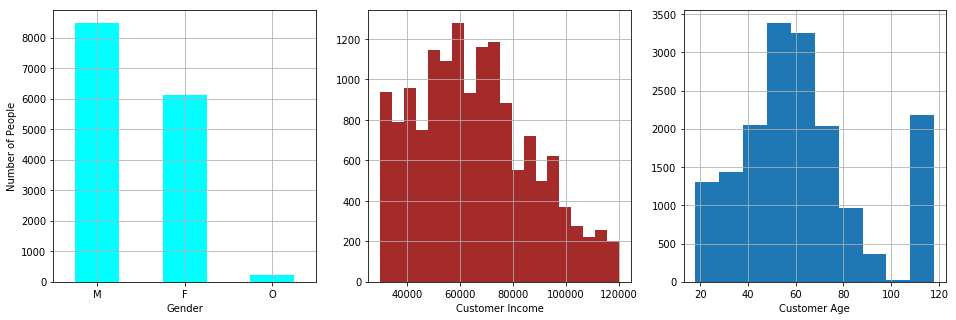

In [8]:
#visualize gender, income and age

plt.figure(figsize=(16,5))

plt.subplot(131)
profile.gender.value_counts().reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, figsize=(16,5), color='aqua');
plt.ylabel('Number of People');
plt.xlabel('Gender');
plt.grid();

plt.subplot(132)
user_income = profile[profile.income > 0].income
plt.xlabel('Customer Income');
plt.hist(user_income, 20, color='brown')
plt.grid()

plt.subplot(133)
profile.age.hist()
plt.xlabel('Customer Age');
plt.hist(20, color='brown');
plt.grid(True)

In [9]:
#verify data related to age=118 and corresponding gender and income columns
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


In [10]:
#check how many unique people are in dataset
profile['id'].nunique()

17000

In [11]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [12]:
#check how many unique events are in dataset
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [13]:
#check number of unique people represented
transcript['person'].nunique()

17000

In [14]:
#check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [15]:
#explore the transcript records for a random user
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [16]:
def clean_portfolio(portfolio):
    '''
    clean the portfolio dataset
    
    Input:
    portfolio - portfolio dataset to be cleaned
    
    Returns:
    portfolio - cleaned portfolio dataset
    
    '''
    # modify the duration from day to hour
    new_portfolio = portfolio.copy()
    new_portfolio['duration'] = new_portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    new_portfolio['web'] = new_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    new_portfolio['email'] = new_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    new_portfolio['mobile'] = new_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    new_portfolio['social'] = new_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(new_portfolio['offer_type'])
    
    # drop columnns: channel and offer_type
    new_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # merge the portfolio and offer_type dataframe to form a cleaned dataframe
    new_portfolio = pd.concat([new_portfolio, offer_type], axis=1, sort=False)
    
    return new_portfolio

In [17]:
new_portfolio = clean_portfolio(portfolio)
new_portfolio.head()

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [18]:
new_portfolio.describe()

,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
count,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000
mean,7.700000,156.000000,4.200000,0.800000,1.0,0.900000,0.600000,0.400000,0.400000,0.200000
std,5.831905,55.713553,3.583915,0.421637,0.0,0.316228,0.516398,0.516398,0.516398,0.421637
min,0.000000,72.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,120.000000,2.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000
50%,8.500000,168.000000,4.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000
75%,10.000000,168.000000,5.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000
max,20.000000,240.000000,10.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
def clean_profile(profile):
    '''
    clean the profile dataset
    
    Input:
    profile - profile dataset to be cleaned
    
    Returns:
    profile - cleaned profile dataset
    
    '''
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop missing values
    profile.dropna(inplace=True)
    
    # define number of days since the user is a memeber of starbucks
    profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    
    return profile

In [20]:
new_profile = clean_profile(profile)
new_profile.head()

,age,became_member_on,gender,id,income,memberdays
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1784
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1851
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1499
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,1575
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1665


In [21]:
new_profile.describe()

,age,became_member_on,income,memberdays
count,14825.000000,1.482500e+04,14825.000000,14825.000000
mean,54.393524,2.016689e+07,65404.991568,1930.478988
std,17.383705,1.188565e+04,21598.299410,419.205158
min,18.000000,2.013073e+07,30000.000000,1408.000000
25%,42.000000,2.016052e+07,49000.000000,1616.000000
50%,55.000000,2.017080e+07,64000.000000,1766.000000
75%,66.000000,2.017123e+07,80000.000000,2205.000000
max,101.000000,2.018073e+07,120000.000000,3231.000000


In [22]:
def display_user_profile():
    '''
    Display user profile with graphs
    '''
    
    # display Histogram of User Age
    user_age = new_profile['age'].plot(kind='hist', bins=20, color='green', title='Customer Age')
    user_age.set_xlabel("Customer Age")
       
    # display Histogram of the days being member
    plt.figure()
    memberdays = new_profile['memberdays'].plot(kind='hist', bins=50, color='brown', title='Time of membership')
    memberdays.set_xlabel("Days")
    
    # display Histogram of User Income
    plt.figure()
    user_income = new_profile['income'].plot(kind='hist', bins=20, color='blue', title='Customer Income')
    user_income.set_xlabel("Income")

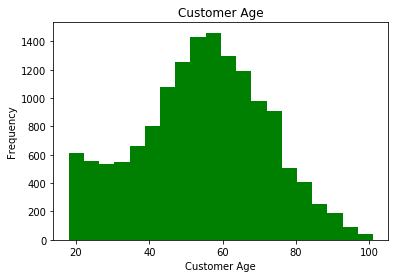

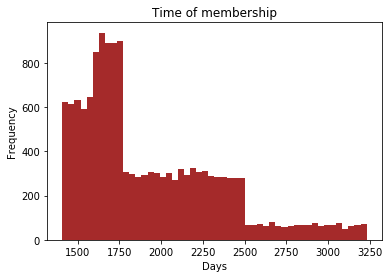

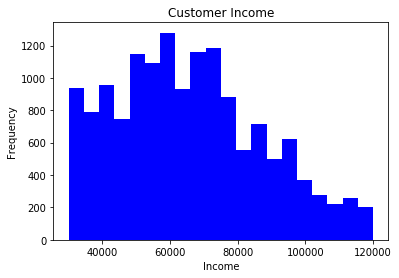

In [23]:
display_user_profile()

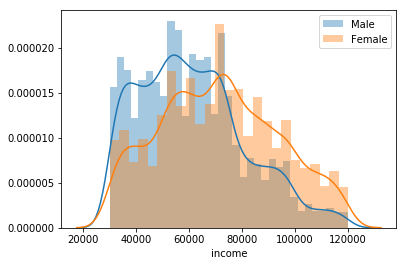

In [34]:
## gender-wise Income Distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

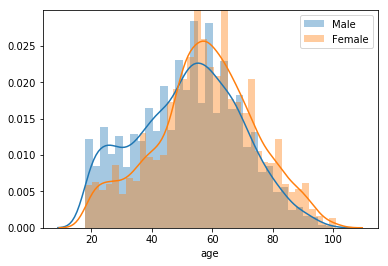

In [35]:
## gender-wise age distribution
sns.distplot(profile[profile.gender=='M'].age,label='Male')
sns.distplot(profile[profile.gender=='F'].age,label='Female')
plt.legend()
plt.show()

In [24]:
def clean_transcript(transcript):
    '''
    clean the transcript dataset in order to return an usable dataset containing offer events
    
    Input:
    transcript - transcript dataset to be cleaned
    
    OUTPUT:
    offers - cleaned offer dataset
    
    '''
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
    offers = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column
    offers['offer_id'] = offers['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offers

In [25]:
offers = clean_transcript(transcript)
offers.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [31]:
offers.describe()

,time
count,167581.000000
mean,353.778412
std,198.301287
min,0.000000
25%,168.000000
50%,408.000000
75%,510.000000
max,714.000000


In [26]:
# check unique events in the new dataset
offers['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [27]:
# check the total of times the offer was sent
offers[offers['event']=='offer received']['time'].unique()

array([  0, 168, 336, 408, 504, 576])

In [28]:
# check the previous user transcript records
offers[offers['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
150598,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
163375,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
201572,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
218394,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd
218395,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d


In [29]:
def create_matrix(offers, filename):
    '''
    Provide an user item matrix that demonstrates the number of offers completed for a particular user
    
    Input:
    offers - a cleaned transcript dataframe
    filename(string) - file name that save the user item matrix
    
    Returns:
    user_matrix where:
        - row represents user 
        - column represents offer
        - value represents the number of offer completed by the user (NaN means that no offer was given)
    
    '''
    # provide an empty user item matrix
    user_matrix = offers.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    
    # the first focus is just on bogo and discount
    user_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offers[(offers['offer_id']==offer_id) & (offers['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # examine if the transaction sequence is equal to: offer received > offer viewed > offer completed
                    # if yes, it means that the user had a positive reaction with the provided offer.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_matrix.loc[person, offer_id] = 0
    
    # store the matrix into a file
    file_1 = open(filename, 'wb')
    pickle.dump(user_matrix,file_1)
    file_1.close()
    
    return user_matrix

In [30]:
#create the df matrix
df = create_matrix(offers, 'user_matrix.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [47]:
df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [40]:
#define train and test size
train_size = int(offers.shape[0]*0.7)
test_size = offers.shape[0] - train_size
train_size, test_size

(117306, 50275)

In [41]:
train_offers = offers[:train_size]
test_offers = offers[train_size:]

In [42]:
train_df = create_matrix(train_offers, 'train_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [43]:
train_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [44]:
test_df = create_matrix(test_offers, 'test_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128

In [45]:
test_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [46]:
test_df.describe()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
count,2627.000000,2693.000000,2464.000000,2498.000000,2550.000000,2496.000000,2469.000000,2793.000000
mean,0.092882,0.365763,0.188312,0.247398,0.187843,0.226763,0.336979,0.346581
std,0.290322,0.488624,0.394143,0.437118,0.395653,0.419778,0.479581,0.478967
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [49]:
def Funk_SVD(complete_matrix, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    Uses a form of FunkSVD to performs a matrix factorization (with no regularization)
    
    Input:
    complete_matrix - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    Returns:
    user_matrix - (numpy array) a user by latent feature matrix
    offer_matrix - (numpy array) a latent feature by offer matrix
    '''
    
    # establish values to be used through the rest of the function
    num_users = complete_matrix.shape[0]
    num_offers = complete_matrix.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_matrix))
    
    # initialize the matrices with random values
    user_matrix = np.random.rand(num_users, latent_features)
    offer_matrix = np.random.rand(latent_features, num_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update the sse
        old_sse = sse_accum
        sse_accum = 0
        
        # for each user-offer pair
        for i in range(num_users):
            for j in range(num_offers):
                
                # if the rating exists
                if complete_matrix[i, j] >= 0:
                    
                    # consider the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_matrix[i, j] - np.dot(user_matrix[i, :], offer_matrix[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_matrix[i, k] += learning_rate * (2*diff*offer_matrix[k, j])
                        offer_matrix[k, j] += learning_rate * (2*diff*user_matrix[i, k])

        # print the results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_matrix, offer_matrix

In [50]:
# create user-by-item matrix
train_data_np = np.array(train_df)
# fit Funk_SVD with the below specified hyper parameters to the training dataset (with latent features = 15)
user_matrix, offer_matrix = Funk_SVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.312176
2 		 0.267471
3 		 0.267116
4 		 0.266750
5 		 0.266379
6 		 0.266003
7 		 0.265621
8 		 0.265234
9 		 0.264841
10 		 0.264442
11 		 0.264035
12 		 0.263621
13 		 0.263200
14 		 0.262769
15 		 0.262330
16 		 0.261881
17 		 0.261421
18 		 0.260950
19 		 0.260467
20 		 0.259971
21 		 0.259462
22 		 0.258938
23 		 0.258398
24 		 0.257841
25 		 0.257266
26 		 0.256672
27 		 0.256057
28 		 0.255421
29 		 0.254761
30 		 0.254076
31 		 0.253364
32 		 0.252624
33 		 0.251854
34 		 0.251052
35 		 0.250215
36 		 0.249343
37 		 0.248432
38 		 0.247481
39 		 0.246487
40 		 0.245447
41 		 0.244360
42 		 0.243222
43 		 0.242031
44 		 0.240785
45 		 0.239480
46 		 0.238115
47 		 0.236685
48 		 0.235190
49 		 0.233626
50 		 0.231990
51 		 0.230281
52 		 0.228496
53 		 0.226633
54 		 0.224690
55 		 0.222666
56 		 0.220559
57 		 0.218369
58 		 0.216094
59 		 0.213735
60 		 0.211291
61 		 0.208764
62 		 0.206154
63 		 0.203464
64 		 0

In [51]:
# trying the best number of latent features (with latent features = 10)
user_matrix_10, offer_matrix_10 = Funk_SVD(train_data_np, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.290207
2 		 0.266245
3 		 0.265786
4 		 0.265314
5 		 0.264839
6 		 0.264361
7 		 0.263880
8 		 0.263396
9 		 0.262908
10 		 0.262417
11 		 0.261922
12 		 0.261423
13 		 0.260919
14 		 0.260410
15 		 0.259896
16 		 0.259376
17 		 0.258851
18 		 0.258318
19 		 0.257779
20 		 0.257232
21 		 0.256677
22 		 0.256114
23 		 0.255541
24 		 0.254959
25 		 0.254366
26 		 0.253761
27 		 0.253145
28 		 0.252515
29 		 0.251872
30 		 0.251213
31 		 0.250539
32 		 0.249848
33 		 0.249139
34 		 0.248411
35 		 0.247663
36 		 0.246892
37 		 0.246099
38 		 0.245280
39 		 0.244436
40 		 0.243564
41 		 0.242663
42 		 0.241731
43 		 0.240766
44 		 0.239766
45 		 0.238730
46 		 0.237656
47 		 0.236541
48 		 0.235384
49 		 0.234184
50 		 0.232936
51 		 0.231641
52 		 0.230296
53 		 0.228898
54 		 0.227447
55 		 0.225940
56 		 0.224375
57 		 0.222752
58 		 0.221069
59 		 0.219323
60 		 0.217516
61 		 0.215644
62 		 0.213709
63 		 0.211709
64 		 0

In [52]:
# trying the best number of latent features (with latent features 5)
user_matrix_5, offer_matrix_5 = Funk_SVD(train_data_np, latent_features=5, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.281652
2 		 0.268373
3 		 0.267520
4 		 0.266666
5 		 0.265810
6 		 0.264953
7 		 0.264095
8 		 0.263234
9 		 0.262373
10 		 0.261509
11 		 0.260643
12 		 0.259775
13 		 0.258905
14 		 0.258033
15 		 0.257158
16 		 0.256280
17 		 0.255400
18 		 0.254516
19 		 0.253629
20 		 0.252739
21 		 0.251844
22 		 0.250946
23 		 0.250043
24 		 0.249136
25 		 0.248223
26 		 0.247306
27 		 0.246382
28 		 0.245453
29 		 0.244517
30 		 0.243574
31 		 0.242624
32 		 0.241667
33 		 0.240701
34 		 0.239727
35 		 0.238744
36 		 0.237751
37 		 0.236748
38 		 0.235734
39 		 0.234710
40 		 0.233674
41 		 0.232626
42 		 0.231565
43 		 0.230491
44 		 0.229403
45 		 0.228301
46 		 0.227184
47 		 0.226052
48 		 0.224904
49 		 0.223740
50 		 0.222560
51 		 0.221362
52 		 0.220147
53 		 0.218914
54 		 0.217662
55 		 0.216393
56 		 0.215104
57 		 0.213797
58 		 0.212470
59 		 0.211125
60 		 0.209760
61 		 0.208376
62 		 0.206973
63 		 0.205551
64 		 0

In [53]:
def pred_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    Used to make predictions of the users reaction
    
    Input:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    Returns:
    pred - the predicted reaction for user_id-offer_id according to Funk_SVD
    '''
    try:
        # use the training data to generate a series of users and offers that matches in training data
        user_ids_series = np.array(train_df.index)
        offer_ids_series = np.array(train_df.columns)

        # define user row and offer Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # take dot product of that row and column in U and V in order to develop a prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        #print("Sorry. This prediction can't be made for this user-offer. Apparently, one of these items (user, offer) does not exist in our database.")
    
        return None

In [56]:
def validation_mat(test_df, user_matrix, offer_matrix):
    '''
    Measure the squared errors for the prediction
    '''
    
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = pred_reaction(user_matrix, offer_matrix, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - pred_reaction(user_matrix, offer_matrix, user_id, offer_id)

                    # observes the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [57]:
# generates the evaluation for latent features = 15
validation_mat(test_df, user_matrix, offer_matrix)

0.331340126898


In [58]:
# generates the evaluation for latent features = 10
validation_mat(test_df, user_matrix_10, offer_matrix_10)

0.325465931019


In [59]:
# generates the evaluation for latent features = 5
validation_mat(test_df, user_matrix_5, offer_matrix_5)

0.320021186261


In [63]:
def rec_offer(user_id, user_matrix, offer_matrix):
    '''
    Recommends a offer for a new user
    '''
    rec = {}
    for offer_id in train_df.columns:
        pred_val = pred_reaction(user_matrix, offer_matrix, user_id, offer_id)
        if pred_val != None:
            rec[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Ops, apparently this user is not in our database. Here are the top best sale offer recommendations for all users.")
        top_offer = best_sale_offer(df)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommended offer for the user ", user_id)
        for offer_id, pred_val in sorted(rec.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [64]:
def best_sale_offer(user_item_matrix):
    '''
    Discover which offer sells the best
    '''

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

In [65]:
# recommend offers for a specific user
rec_offer('0009655768c64bdeb2e877511632db8f', user_matrix, offer_matrix)

recommended offer for the user  0009655768c64bdeb2e877511632db8f
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.97
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.57
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.45
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.09
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.08
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.0
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.0
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  -0.47


In [66]:
# recommend offers for a specific user
rec_offer('0610b486422d4921ae7d2bf64640c50b', user_matrix, offer_matrix)

recommended offer for the user  0610b486422d4921ae7d2bf64640c50b
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.79
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.54
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.45
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.44
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.1
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.04
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  -0.09
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  -0.14


Ops, apparently this user is not in our database. Here are the top best sale offer recommendations for all users.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


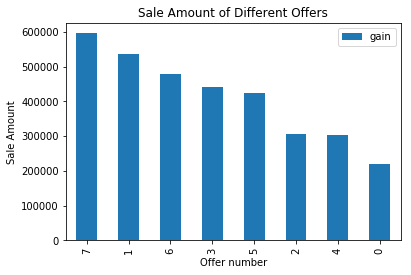

In [67]:
# recommend top best offer to a new user
rec_offer('new_user', user_matrix, offer_matrix)

In [68]:
def gender_offers(df):
    '''
    Discover the offers response for different genders. Considereing bogo and discount
    Return a plotted bar chart
    '''
    
    # initialize the datasets: gender resp and the gender sent
    gender_resp = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

    # count the amount of completed offers based on gender
    for offer_type in ['bogo', 'discount']:
        for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
            # count the number of users responsed our offers.
            gender_resp[offer_type] = gender_resp[offer_type].add(profile[profile['id'].isin(df[df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offers sent
            gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(df[df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offers = (gender_resp / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offers.set_xlabel("Gender")
    gender_offers.set_ylabel("Percentage")

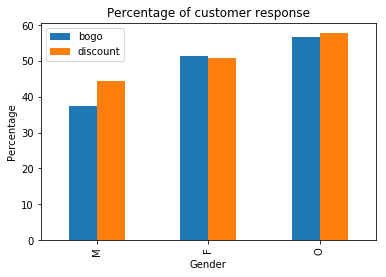

In [69]:
gender_offers(df)

In [ ]:
# profile: create readable date format for became_member_on column.
#profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")

In [ ]:
# profile: add start_year column
#profile['start_year'] = profile.became_member_on.dt.year
#profile["start_month"] = profile.became_member_on.dt.month